In [1]:
import pandas as pd
from collections import Counter
import pprint
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

Load pre-trained embedding. See readme for training your own.

In [2]:
%load_ext autoreload
%autoreload 2
from code.feiii_transformers import _EmbeddingHolder
embedding = _EmbeddingHolder()
embedding.load('embedding')

# Load data

In [3]:
%load_ext autoreload
%autoreload 2

from code.feiii_experiment import evaluate, kfold
from code.feiii_data import DataHolder
from code.feiii_pipeline import FeiiiPipeline


def pp(obj):
    return pprint.pformat(obj).replace('\n','<br />')

data = DataHolder(eval_docs=2)
print('done')

out = '<table><tr><th></th><th>TRAINING</th><th>TESTING SET</th></tr>'
out+= '<tr><td>#ROWS</td><td>'+str(len(data.train_full))+'</td><td>'+str(len(data.test))+'</td></tr>'
out+= '<tr><td>ROLES</td><td>'+pp(dict(Counter(data.train_full['grp'])))+'</td><td>'+pp(dict(Counter(data.test['grp'])))+'</td></tr>'
out+= '<tr><td>DOCUMENTS</td><td>'+pp(dict(Counter(data.train_full['SOURCE'])))+'</td><td>'+pp(dict(Counter(data.test['SOURCE'])))+'</td></tr>'
out+= '<tr><td>COMPANIES</td><td>'+pp(dict(Counter(data.train_full['FILER_NAME'])))+'</td><td>'+pp(dict(Counter(data.test['FILER_NAME'])))+'</td></tr>'
out+= '<tr><td>Expert ratings</td><td>'
tmp = Counter(data.train_full['rating'])
out+= "ALL: [H]{:_>4d} [R]{:_>4d} [N]{:_>4d} [I]{:_>4d}<br/>".format(
    tmp.get('highly',0),tmp.get('relevant',0),tmp.get('neutral',0),tmp.get('irrelevant',0))
for c in data.train_full.filter(regex=("RATING")):
    tmp = Counter(data.train_full[c])
    out+="[H]{:_>3d} [R]{:_>3d} [N]{:_>3d} [I]{:_>3d} [x]{:_>3d} ({})<br/>".format(
        tmp.get("Highly relevant", 0), tmp.get("Relevant", 0),
        tmp.get("Neutral", 0),tmp.get("Irrelevant", 0),
        tmp.get(np.nan, 0), c)
out+= '</td><td>'
tmp = Counter(data.test['rating'])
out+= "ALL: [H]{:_>4d} [R]{:_>4d} [N]{:_>4d} [I]{:_>4d}<br/>".format(
    tmp.get('highly',0),tmp.get('relevant',0),tmp.get('neutral',0),tmp.get('irrelevant',0))
out+= '</td></tr>'
out+= '</table>'

HTML(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
reading file STATE-STREET_2016.csv with 23 entries.
reading file STATE-STREET_2014.csv with 26 entries.
reading file PNC_2016.csv with 33 entries.
reading file PNC_2014.csv with 38 entries.
reading file JPM_2016.csv with 52 entries.
reading file COMERICA_2016.csv with 11 entries.
reading file FIFTH-THIRD_2014.csv with 36 entries.
reading file CITIGROUP_2014.csv with 52 entries.
reading file AMERICAN-EXPRESS_2015.csv with 11 entries.
reading file BANK-OF-AMERICA_2015.csv with 74 entries.
reading file ALLY_2016.csv with 44 entries.
reading file CITIGROUP_2016.csv with 50 entries.
reading file ALLY_2014.csv with 40 entries.
reading file SUNTRUST_2013.csv with 35 entries.
reading file DISCOVER_2014.csv with 41 entries.
reading file MORGAN-STANLEY_2015.csv with 128 entries.
reading file SUNTRUST_2016.csv with 27 entries.
reading file BBT_2014.csv with 14 entries.
reading file GENERAL-ELECTRIC_2013.csv wi

,TRAINING,TESTING SET
#ROWS,975,900
ROLES,"{'affiliate': 186, 'agent': 61, 'counterpart': 64, 'guarantor': 34, 'insurer': 19, 'issuer': 129, 'seller': 20, 'servicer': 21, 'trustee': 420, 'underwriter': 21}","{'affiliate': 129, 'agent': 40, 'counterpart': 108, 'guarantor': 28, 'insurer': 47, 'issuer': 98, 'seller': 49, 'servicer': 57, 'trustee': 304, 'underwriter': 40}"
DOCUMENTS,"{'1393612-2013-FY': 41, '19617-2015-FY': 52, '28412-2015-FY': 11, '35527-2013-FY': 36, '35527-2014-FY': 46, '36270-m&t-2012': 21, '36270-m&t-2014': 21, '40545-2012-FY': 21, '40729-2013-FY': 40, '40729-2015-FY': 44, '4962-2014-FY': 11, '70858-2012-FY': 88, '70858-2014-FY': 74, '713676-2013-FY': 38, '713676-2015-FY': 33, '73124-2012-FY': 18, '750556-2012-FY': 35, '750556-2015-FY': 27, '831001-2013-FY': 52, '831001-2015-FY': 50, '895421-2014-FY': 128, '92230-2013-FY': 14, '927628-2012-FY': 25, '93751-2013-FY': 26, '93751-2015-FY': 23}","{'1026214-2011-Q2': 64, '1026214-2013-FY': 99, '109380-2014-FY': 13, '1390777-2015-Q1': 26, '1393612-2010-FY': 11, '19617-2011-FY': 67, '28412-2012-FY': 11, '310522-2012-FY': 59, '310522-2013-Q2': 21, '316709-2015-FY': 14, '36104-_2015-FY': 8, '36270-m&t-2010': 18, '40545-2015-FY': 27, '40729-2012-Q3': 23, '4962-2015-FY': 19, '70858-2013-FY': 81, '713676-2014-FY': 33, '73124-2015-FY': 28, '831001-2011-FY': 37, '886982-2013-FY': 36, '895421-2015-FY': 134, '91576-2012-FY': 10, '92230-2010-FY': 21, '927628-2010-FY': 20, '93751-2010-FY': 20}"
COMPANIES,"{'AMERICAN EXPRESS CO': 11, 'Ally Financial Inc': 84, 'BANK OF AMERICA CORP': 162, 'BB&T CORP': 14, 'CAPITAL ONE FINANCIAL CORP': 25, 'CITIGROUP INC': 102, 'COMERICA INC': 11, 'Discover Financial Services': 41, 'FIFTH THIRD BANCORP': 82, 'GENERAL ELECTRIC CO': 21, 'JPMORGAN CHASE & CO': 52, 'M&T BANK CORP': 42, 'MORGAN STANLEY': 128, 'NORTHERN TRUST CORP': 18, 'PNC FINANCIAL SERVICES GROUP INC': 71, 'STATE STREET CORP': 49, 'SUNTRUST BANKS INC': 62}","{'AMERICAN EXPRESS CO': 19, 'Ally Financial Inc': 23, 'BANK OF AMERICA CORP': 81, 'BB&T CORP': 21, 'Bank of New York Mellon Corp': 26, 'CAPITAL ONE FINANCIAL CORP': 20, 'CITIGROUP INC': 37, 'COMERICA INC': 11, 'Discover Financial Services': 11, 'FEDERAL_HOME_LOAN_MORTGAGE_CORP': 163, 'FEDERAL_NATIONAL_MORTGAGE_ASSOCIATION_FANNIE_MAE': 80, 'GENERAL ELECTRIC CO': 27, 'GOLDMAN SACHS GROUP INC': 36, 'JPMORGAN CHASE & CO': 67, 'KEYCORP': 10, 'M&T BANK CORP': 18, 'MORGAN STANLEY': 134, 'NORTHERN TRUST CORP': 28, 'PNC FINANCIAL SERVICES GROUP INC': 33, 'SCHWAB_CHARLES_CORP ': 14, 'STATE STREET CORP': 20, 'US_BANCORP': 8, 'ZIONS BANCORPORATION': 13}"
Expert ratings,ALL: [H]_295 [R]_283 [N]_307 [I]__90[H]149 [R]_93 [N]139 [I]_28 [x]566 (RATING_EXPERT_1)[H]101 [R]_35 [N]_83 [I]__7 [x]749 (RATING_EXPERT_1.1)[H]__0 [R]_20 [N]__0 [I]__0 [x]955 (RATING_EXPERT_10)[H]_58 [R]163 [N]131 [I]_14 [x]609 (RATING_EXPERT_2)[H]__8 [R]__8 [N]_15 [I]_29 [x]915 (RATING_EXPERT_3)[H]__5 [R]_23 [N]__5 [I]__2 [x]940 (RATING_EXPERT_4)[H]__7 [R]_29 [N]_41 [I]__3 [x]895 (RATING_EXPERT_5)[H]_10 [R]_34 [N]__6 [I]_10 [x]915 (RATING_EXPERT_6)[H]_10 [R]_27 [N]_36 [I]__2 [x]900 (RATING_EXPERT_7)[H]_62 [R]__1 [N]__1 [I]_10 [x]901 (RATING_EXPERT_9),ALL: [H]_309 [R]_369 [N]_142 [I]__80


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import code.feiii_transformers as ft

params_ = {
    'cv': {
        'ngram_range': (1, 3),
        'min_df': 0.4,
        'max_df': 0.6,
        'stop_words': 'english'
    },
    'tt': {
        'use_idf': True,
        'sublinear_tf': True,
    },
    'emb': {
        'num_files': 30,
        'num_epoch': 20
    },
    'logit': {
        'loss': 'log',  # ['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
        'penalty': 'l2',
        'shuffle': True,
        'alpha': 1e-4,
        'n_iter': 15,
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'rf': {
        'n_estimators': 20,
        'criterion': 'gini',  # gini or entropy
        'max_features': 'auto',  # int, float, auto, sqrt, log2, None
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'svm': {
        'C': 1.0,
        'kernel': 'sigmoid',  # linear’, ‘poly’, ‘rbf’, ‘sigmoid’
        'probability': True,
        'class_weight': 'balanced',
        'decision_function_shape': 'ovr',  # ovo, ovr
        'random_state': 42
    }
}

def pipeline():
    pipln = 'all_vote'
    if pipln == 'all_union':
        line = [
            ('union', FeatureUnion(
                transformer_list=[
                    ('emb', Pipeline([
                        ('emb', ft.Embedder(embedding))
                    ])),
                    ('syntax', Pipeline([
                        ('feats', ft.SyntaxFeatures()),
                    ])),
                    ('bow', Pipeline([
                        ('lem', ft.Lemmatiser()),
                        ('vect', CountVectorizer(**params_['cv'])),
                        ('tfidf', TfidfTransformer(**params_['tt']))
                    ]))
                ],
                transformer_weights={
                    'syntax': 1,
                    'bow': 1
                },
            )),
            # ('clf', SGDClassifier(**params_['svm']))
            ('clf', SGDClassifier(**params_['logit']))
            # ('clf', RandomForestClassifier(**params_['rf']))
        ]
    elif pipln == 'all_vote':
        line = [
            ('clf', VotingClassifier(
                voting='soft',  # hard, soft
                # weights=[2,1,2],
                estimators=[
                    ('syn', Pipeline([
                        ('feats', ft.SyntaxFeatures()),
                        ('rf', RandomForestClassifier(**params_['rf'])),
                        # ('svc', SVC(**params_['svm']))
                    ])),
                    ('emb', Pipeline([
                        ('emb', ft.Embedder(embedding)),
                        ('svc', SVC(**params_['svm']))
                    ])),
                    ('bow', Pipeline([
                        ('lem', ft.Lemmatiser()),
                        ('vect', CountVectorizer(**params_['cv'])),
                        ('tfidf', TfidfTransformer(**params_['tt'])),
                        ('svc', SVC(**params_['svm']))
                        # ('bclf', SGDClassifier(**params_['logit']))
                    ]))
                ]))]
    elif pipln == 'syn':
        line = [
            ('feats', ft.SyntaxFeatures()),
            ('clf', RandomForestClassifier(**params_['rf']))
        ]
    elif pipln == 'emb':
        line = [
            ('emb', ft.Embedder(embedding)),
            ('clf', SVC(**params_['svm']))
           # ('bclf', SGDClassifier(**params_['logit']))
        ]
    else:  # pipln == 'bow'
        line = [
            ('lem', ft.Lemmatiser()),
            ('vect', CountVectorizer(**params_['cv'])),
            ('tfidf', TfidfTransformer(**params_['tt'])),
            ('svc', SVC(**params_['svm']))
            #('clf', SGDClassifier(**params_['logit']))
        ]
    return FeiiiPipeline(line=line, embedding=embedding)

def score_func(x):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = (x.argmax(axis=1)+1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

Execute the following line in case of errors during training.

In [10]:
data.shuffle_train_eval(n_docs_eval=0, max_tries=5)

# Train

In [10]:
fm, m, res, macro_res, conf_matrix_role, conf_matrix_full = evaluate(data, pipeline, score_func=score_func,predict_on='test')

Items in training set: 849 (87.08%)
Items in eval set: 126
Items in test set: 900
 = 1875
Number of source documents: 50 total, 22 train, 3 eval 25 test
Absolute (training): IR 87.00, N 240.00, R 241.00, HR 281.00
Relative (training): IR 0.10, N 0.28, R 0.28, HR 0.33
Absolute (eval): IR 3.00, N 67.00, R 42.00, HR 14.00
Relative (eval): IR 0.02, N 0.53, R 0.33, HR 0.11
Role samples for TRUSTEE in train: 373, eval: 47, test: 304
Role samples for COUNTERPART in train: 58, eval: 6, test: 108
Role samples for SELLER in train: 18, eval: 2, test: 49
Role samples for GUARANTOR in train: 19, eval: 15, test: 28
Role samples for ISSUER in train: 116, eval: 13, test: 98
Role samples for AGENT in train: 53, eval: 8, test: 40
Role samples for UNDERWRITER in train: 21, eval: 0, test: 40
Role samples for SERVICER in train: 18, eval: 3, test: 57
Role samples for AFFILIATE in train: 154, eval: 32, test: 129
Role samples for INSURER in train: 19, eval: 0, test: 47


KeyboardInterrupt: 

In [11]:
res, macro_res, conf_matrix_role, conf_matrix_full = kfold(5, data, pipeline, score_func, predict_on='test')

Leaving 3 docs out per fold


===                      CROSSEVAL ITERATION 1/5                     =====


Items in training set: 774 (79.38%)
Items in eval set: 201
Items in test set: 900
 = 1875
Number of source documents: 50 total, 22 train, 3 eval 25 test
Absolute (training): IR 84.00, N 245.00, R 248.00, HR 197.00
Relative (training): IR 0.11, N 0.32, R 0.32, HR 0.25
Absolute (eval): IR 6.00, N 62.00, R 35.00, HR 98.00
Relative (eval): IR 0.03, N 0.31, R 0.17, HR 0.49
Role samples for TRUSTEE in train: 291, eval: 129, test: 304
Role samples for COUNTERPART in train: 63, eval: 1, test: 108
Role samples for SELLER in train: 17, eval: 3, test: 49
Role samples for GUARANTOR in train: 34, eval: 0, test: 28
Role samples for ISSUER in train: 109, eval: 20, test: 98
Role samples for AGENT in train: 49, eval: 12, test: 40
Role samples for UNDERWRITER in train: 19, eval: 2, test: 40
Role samples for SERVICER in train: 19, eval: 2, test: 57
Role samples for AFFILIATE in train: 155, eval: 31,

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.904693093232 | std = 0.0224933107974
NDCG for worst case (inverted best) order:
 > ndcg = 0.810440241115
Accuracy | role : 0.785714285714
Accuracy | full : 0.535714285714
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.17      0.33      0.22         3
   relevant       0.85      0.50      0.63        22
     highly       0.33      1.00      0.50         3

avg / total       0.72      0.54      0.57        28

[[ 0  0  0  0]
 [ 0  1  2  0]
 [ 0  5 11  6]
 [ 0  0  0  3]]
> NDCG Score | role | categ  | 0.84067
> NDCG Score | role | proba* | 0.90207
> NDCG Score | full | categ  | 0.95140
> NDCG Score | full | proba* | 0.95381
=== ISSUER ======
Items in training set: 109 (84.50%)
Items in eval set: 20
Items in test set: 98
 = 227
Number of source documents: 46 total, 21 train, 3 eval 22 test
Absolute (training): IR 29.00, N 43.00, R 23.00, HR 14.00
Relative (training

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.905324891457 | std = 0.0255478279368
NDCG for worst case (inverted best) order:
 > ndcg = 0.810440241115
Accuracy | role : 0.785714285714
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.17      0.33      0.22         3
   relevant       0.79      0.50      0.61        22
     highly       0.25      0.67      0.36         3

avg / total       0.66      0.50      0.54        28

[[ 0  0  0  0]
 [ 0  1  2  0]
 [ 0  5 11  6]
 [ 0  0  1  2]]
> NDCG Score | role | categ  | 0.84067
> NDCG Score | role | proba* | 0.90207
> NDCG Score | full | categ  | 0.91938
> NDCG Score | full | proba* | 0.94848
=== ISSUER ======
Items in training set: 119 (92.25%)
Items in eval set: 10
Items in test set: 98
 = 227
Number of source documents: 46 total, 21 train, 3 eval 22 test
Absolute (training): IR 27.00, N 43.00, R 28.00, HR 21.00
Relative (training): IR 0.23,

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.882757704292 | std = 0.02316517598
NDCG for worst case (inverted best) order:
 > ndcg = 0.717524169319
Accuracy | role : 0.157894736842
Accuracy | full : 0.385964912281
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.17      0.11      0.13         9
   relevant       0.56      0.47      0.51        38
     highly       0.16      0.43      0.23         7

avg / total       0.42      0.39      0.39        57

[[ 0  1  2  0]
 [ 0  1  8  0]
 [ 0  4 18 16]
 [ 0  0  4  3]]
> NDCG Score | role | categ  | 0.85835
> NDCG Score | role | proba* | 0.90150
> NDCG Score | full | categ  | 0.91187
> NDCG Score | full | proba* | 0.90128
=== TRUSTEE ======
Items in training set: 390 (92.86%)
Items in eval set: 30
Items in test set: 304
 = 724
Number of source documents: 40 total, 19 train, 2 eval 19 test
Absolute (training): IR 20.00, N 137.00, R 78.00, HR 155.00
Relative (traini

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.867105950862 | std = 0.0375874481987
NDCG for worst case (inverted best) order:
 > ndcg = 0.674252161736
Accuracy | role : 0.34693877551
Accuracy | full : 0.469387755102
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.00      0.00      0.00        10
   relevant       0.39      0.65      0.49        17
     highly       0.60      0.67      0.63        18

avg / total       0.36      0.47      0.40        49

[[ 0  0  3  1]
 [ 0  0  9  1]
 [ 0  0 11  6]
 [ 0  1  5 12]]
> NDCG Score | role | categ  | 0.80424
> NDCG Score | role | proba* | 0.95403
> NDCG Score | full | categ  | 0.94446
> NDCG Score | full | proba* | 0.93493
=== AGENT ======
Items in training set: 49 (80.33%)
Items in eval set: 12
Items in test set: 40
 = 101
Number of source documents: 25 total, 13 train, 3 eval 9 test
Absolute (training): IR 2.00, N 27.00, R 17.00, HR 3.00
Relative (training): IR 

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.916107269535 | std = 0.0308838179733
NDCG for worst case (inverted best) order:
 > ndcg = 0.721180267881
Accuracy | role : 0.375
Accuracy | full : 0.625
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.00      0.00      0.00         2
   relevant       0.58      0.73      0.65        15
     highly       0.70      0.70      0.70        20

avg / total       0.57      0.62      0.59        40

[[ 0  0  3  0]
 [ 0  0  0  2]
 [ 0  0 11  4]
 [ 0  1  5 14]]
> NDCG Score | role | categ  | 0.86908
> NDCG Score | role | proba* | 0.88818
> NDCG Score | full | categ  | 0.96397
> NDCG Score | full | proba* | 0.96922
=== SERVICER ======
Items in training set: 18 (85.71%)
Items in eval set: 3
Items in test set: 57
 = 78
Number of source documents: 18 total, 7 train, 1 eval 10 test
Absolute (training): IR 0.00, N 6.00, R 3.00, HR 9.00
Relative (training): IR 0.00, N 0.33, R 0.

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.902033514386 | std = 0.0306103766175
NDCG for worst case (inverted best) order:
 > ndcg = 0.755505248883
Accuracy | role : 0.617021276596
Accuracy | full : 0.446808510638
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.25      0.14      0.18         7
   relevant       0.27      0.16      0.20        19
     highly       0.53      0.85      0.65        20

avg / total       0.37      0.45      0.39        47

[[ 0  0  1  0]
 [ 0  1  4  2]
 [ 0  3  3 13]
 [ 0  0  3 17]]
> NDCG Score | role | categ  | 0.92645
> NDCG Score | role | proba* | 0.94048
> NDCG Score | full | categ  | 0.90220
> NDCG Score | full | proba* | 0.98437
TOTAL NDCG | role | categ  | 0.96265
TOTAL NDCG | role | proba* | 0.96103
TOTAL NDCG | full | categ  | 0.96790
TOTAL NDCG | full | proba* | 0.97142
baseline_rand 10
baseline_worst 10
ndcg_role 10
ndcg_full 10
ndcg_role_proba 10
ndcg_full_proba 

# Evaluate trained classifier

In [12]:
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.458573,0.404886,0.882620,0.716242,0.437448,0.320963,0.927835,0.934710,0.885366,0.896086
std,0.099130,0.157694,0.032637,0.061140,0.099786,0.174052,0.040567,0.046428,0.056323,0.068369
min,0.228070,0.122807,0.807877,0.621678,0.240732,0.026864,0.833604,0.838799,0.803756,0.756926
25%,0.400463,0.343679,0.860860,0.674252,0.372816,0.182598,0.904603,0.901757,0.840668,0.852156
50%,0.480921,0.375000,0.885455,0.718914,0.455710,0.287273,0.933542,0.947459,0.890098,0.907261
75%,0.510530,0.480531,0.906200,0.755505,0.506500,0.425648,0.957972,0.975861,0.936421,0.951481
max,0.680851,0.785714,0.931530,0.814145,0.642857,0.691429,0.991694,0.992436,0.978115,0.988567


In [13]:
out = ""
for ir, r in enumerate(data.get_roles()):
    out+="<h2>"+r.upper()+"</h2>"
    out+=pd.DataFrame(res).iloc[[ir+(ii*5) for ii in range(5)]].describe().to_html()
HTML(out)

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.450000,0.583069,0.888915,0.757137,0.449566,0.513951,0.932977,0.933457,0.873171,0.866518
std,0.074788,0.252112,0.023027,0.072988,0.127639,0.247514,0.016366,0.020814,0.062850,0.061798
min,0.351852,0.240741,0.860437,0.677183,0.270559,0.178709,0.915284,0.903181,0.804398,0.764600
25%,0.398148,0.388889,0.867251,0.677183,0.364652,0.317714,0.919376,0.921867,0.840668,0.851214
50%,0.464286,0.714286,0.904693,0.810440,0.498430,0.690476,0.930722,0.939955,0.840668,0.902075
75%,0.500000,0.785714,0.905325,0.810440,0.542929,0.691429,0.948101,0.948476,0.937921,0.902075
max,0.535714,0.785714,0.906869,0.810440,0.571259,0.691429,0.951402,0.953807,0.942201,0.912627
,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [19]:
for ir, r in enumerate(data.get_roles()):
    tmp = pd.DataFrame(res).iloc[[ir+(ii*5) for ii in range(5)]].describe()
    m = tmp.loc['mean']['baseline_worst']
    print("{: <12}: {:.4f} (ndcg), {:.4f} (rand) | min: {:.4f}, rand: {:.4f}, ndcg: {:.4f}".format(
        r.upper(),
        (tmp.loc['mean']['ndcg_full_proba']-m)/(1-m),
        (tmp.loc['mean']['baseline_rand']-m)/(1-m),
        m,tmp.loc['mean']['baseline_rand'], tmp.loc['mean']['ndcg_full_proba']) )
    
tmp = pd.DataFrame(res).describe()
m = tmp.loc['mean']['baseline_worst']
print("{: <12}: {:.4f} (ndcg), {:.4f} (rand) | min: {:.4f}, rand: {:.4f}, ndcg: {:.4f}".format(
    'ALL',
    (tmp.loc['mean']['ndcg_full_proba']-m)/(1-m),
    (tmp.loc['mean']['baseline_rand']-m)/(1-m),
    m,tmp.loc['mean']['baseline_rand'], tmp.loc['mean']['ndcg_full_proba']) )

GUARANTOR   : 0.7260 (ndcg), 0.5426 (rand) | min: 0.7571, rand: 0.8889, ndcg: 0.9335
ISSUER      : 0.6979 (ndcg), 0.5359 (rand) | min: 0.6427, rand: 0.8342, ndcg: 0.8921
UNDERWRITER : 0.8016 (ndcg), 0.6300 (rand) | min: 0.6928, rand: 0.8863, ndcg: 0.9390
SERVICER    : 0.6498 (ndcg), 0.5947 (rand) | min: 0.7186, rand: 0.8860, ndcg: 0.9015
TRUSTEE     : 0.8667 (ndcg), 0.6274 (rand) | min: 0.7907, rand: 0.9220, ndcg: 0.9721
COUNTERPART : 0.7476 (ndcg), 0.5555 (rand) | min: 0.7305, rand: 0.8802, ndcg: 0.9320
SELLER      : 0.7381 (ndcg), 0.5515 (rand) | min: 0.6532, rand: 0.8445, ndcg: 0.9092
AGENT       : 0.7401 (ndcg), 0.6117 (rand) | min: 0.6786, rand: 0.8752, ndcg: 0.9165
AFFILIATE   : 0.7172 (ndcg), 0.6013 (rand) | min: 0.7192, rand: 0.8880, ndcg: 0.9206
INSURER     : 0.8766 (ndcg), 0.6224 (rand) | min: 0.7790, rand: 0.9165, ndcg: 0.9727
ALL         : 0.7699 (ndcg), 0.5863 (rand) | min: 0.7162, rand: 0.8826, ndcg: 0.9347


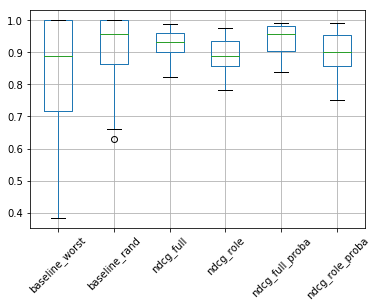

In [41]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

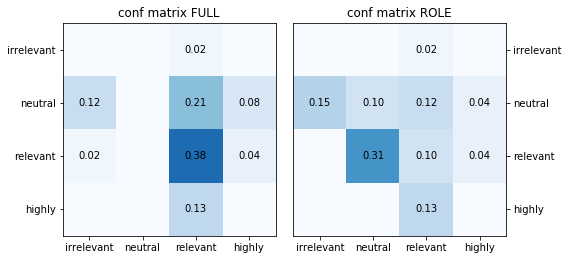

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

# Save

affiliate 129
agent 40
counterpart 108
guarantor 28
insurer 47
issuer 98
seller 49
servicer 57
trustee 304
underwriter 40


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde73627f98>], dtype=object)

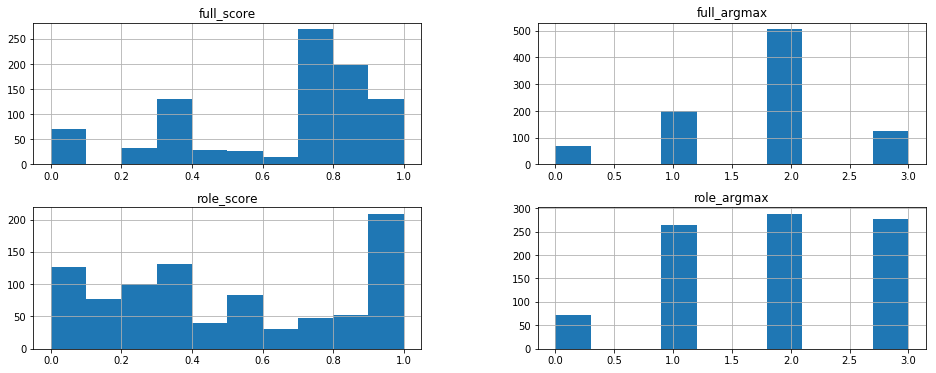

In [221]:
%matplotlib inline
def score_func(x, norm=True):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

distribution_full = []
distribution_role = []
scores_full = []
scores_role = []

scored_full = []
scored_role = []

for role, frm in data.test.groupby('grp'):
    print(role, len(frm))
    fmpred, fmppred = fm.predict(frm)
    mpred, mppred = m[role].predict(frm)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(fmppred)
    scored_full.append(tmp)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(mppred)
    scored_role.append(tmp)
    
    distribution_full += list(fmpred)
    distribution_role += list(mpred)
    scores_full += list(score_func(fmppred))
    scores_role += list(score_func(mppred))
    
classifier = 'bow'
cols = ['SCORE', 'UNIQUE_ID', 'DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK', 'FILING_INTERVAL', 'FILING_DATE', 
        'MENTIONED_FINANCIAL_ENTITY', 'ROLE', 'THREE_SENTENCES']

pd.concat(scored_full).sort_values(by=['grp', 'SCORE'], 
                                   ascending=[True, False])[cols].to_csv('scored_full_'+classifier+'.csv',
                                                                         index=False)
pd.concat(scored_role).sort_values(by=['grp', 'SCORE'], 
                                   ascending=[True, False])[cols].to_csv('scored_role_'+classifier+'.csv',
                                                                         index=False)


f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=2)
pd.DataFrame({'full_score':scores_full}).hist(ax=ax[0][0])
pd.DataFrame({'full_argmax':distribution_full}).hist(ax=ax[0][1])
pd.DataFrame({'role_score':scores_role}).hist(ax=ax[1][0])
pd.DataFrame({'role_argmax':distribution_role}).hist(ax=ax[1][1])

# Experiment with scoring functions

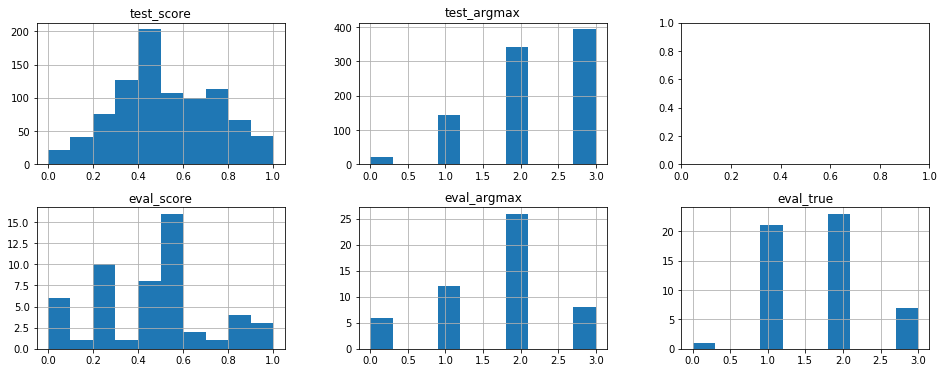

,test
count,900.000000
mean,0.522213
std,0.221250
min,0.000000
25%,0.384295
50%,0.489785
75%,0.698920
max,1.000000


In [206]:
%matplotlib inline
def score_func(x, norm=True):
    #return x.argmax(axis=1)
    #return np.sum(x * (np.ones_like(x)+ x.argmax(axis=1)), axis=1)
    #xx = ((x.argmax(axis=1))*x.argmax(axis=1)*x.max(axis=1))
    #xx= np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,a)])
    #xx = x.argmax(axis=1)+x.max(axis=1)
    #xx = x.argmax(axis=1)*x.max(axis=1)*x.max(axis=1)
    #return xx
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

#pred, ppred = fm.predict(data.test)
#epred, eppred = fm.predict(data.eval)

f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=3)
pd.DataFrame({'test_score':score_func(ppred)}).hist(ax=ax[0][0])
pd.DataFrame({'test_argmax':pred}).hist(ax=ax[0][1])
pd.DataFrame({'eval_true':data.get_target(frm='eval')}).hist(ax=ax[1][2])
pd.DataFrame({'eval_score':score_func(eppred)}).hist(ax=ax[1][0])
pd.DataFrame({'eval_argmax':epred}).hist(ax=ax[1][1])
plt.show()
pd.DataFrame({'test':score_func(ppred, norm=False)}).describe()
#pd.DataFrame({'eval':score_func(eppred)})
#pd.DataFrame({'ppred':score_func(ppred), 'eppred':score_func(eppred)}).describe()